In [92]:
#importing all the packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
#from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [93]:
#importing data
listings = pd.read_csv("listing_update/listingsUpdateOut.csv")
neighb = pd.read_csv("neighbourhoods_update/neighbourhoods_update.csv", sep = ",")
main = pd.merge(listings, neighb, how="inner", on="neighbourhood_group")

In [109]:
#selecting variables arbitrarily
data = main[["price", "number_of_reviews",'coefficient_of_location', "host_response_rate", "population_density",
             "nr_of_bathrooms", "bedrooms", "review_scores_rating", "purchase_power_pc", "minimum_nights", "crime_rate_pc"]]

In [110]:
y = data[["price"]] #target variable
x = data[["number_of_reviews", 'coefficient_of_location', "nr_of_bathrooms", "bedrooms", "review_scores_rating", "purchase_power_pc", "crime_rate_pc", "population_density", "host_response_rate", "minimum_nights"]]

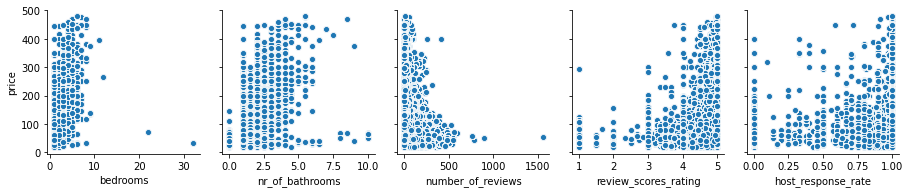

In [100]:
sns.pairplot(data, x_vars=["bedrooms", "nr_of_bathrooms", "number_of_reviews", "review_scores_rating", "host_response_rate"], y_vars=["price"], kind="scatter")

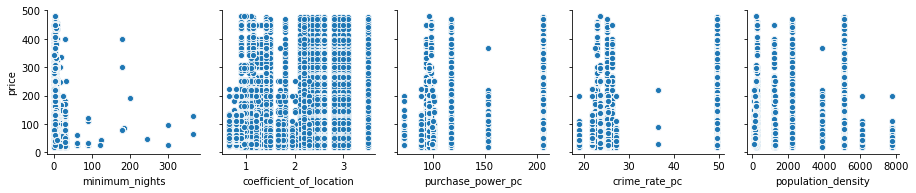

In [111]:
sns.pairplot(data, x_vars=["minimum_nights","coefficient_of_location", "purchase_power_pc", "crime_rate_pc", "population_density"], y_vars=["price"], kind="scatter")

In [112]:
x1 = sm.add_constant(x)
model = sm.OLS(y, x1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 1.081e+04
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:15:03   Log-Likelihood:            -1.0300e+06
No. Observations:              196788   AIC:                         2.060e+06
Df Residuals:                  196777   BIC:                         2.060e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -32.1255      1.722    -18.653      0.000     -35.501     -28.750
number_of_reviews          -0.0419      0.001    -33.954      0.000      -0.044      -0.039
coefficient_of_location     0.5605      0.195      2.881      0.004       0.179       0.942
nr_of_bathrooms            12.2141      0.135     90.458      0.000      11.949      12.479
bedrooms                   25.7540      0.106    242.023      0.000      25.545      25.963
review_scores_rating       14.3066      0.260     55.112      0.000      13.798      14.815
purchase_power_pc           0.1596      0.025      6.396      0.000       0.111       0.209
crime_rate_pc              -0.2061      0.098     -2.100      0.036      -0.398      -0.014
population_density         -0.0031      0.000    -10.758      0.000      -0.004      -0.003
host_response_rate        -19.7362      0.751    -26.277      0.000     -21.208     -18.264
minimum_nights              0.0652      0.010      6.574      0.000       0.046       0.085
==============================================================================
Omnibus:                    90179.275   Durbin-Watson:                   0.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4940030.787
Skew:                           1.432   Prob(JB):                         0.00
Kurtosis:                      27.378   Cond. No.                     8.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [113]:
#very interesting conclusions can be withdrawn from the table above
# regardless, now we will try to maximize the performance of our multilinear regression

#Removing outliers for all variables
# Outliers are defined as values > 3 standard deviations from mean
data = pd.DataFrame(data)
data_out = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data_log = np.log(data_out)

<ipython-input-113-bc3c63ee97e8>:8: RuntimeWarning: divide by zero encountered in log
  data_log = np.log(data_out)


In [114]:
## Correlation Matrix 
df = pd.DataFrame(data_out)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,price,number_of_reviews,coefficient_of_location,host_response_rate,population_density,nr_of_bathrooms,bedrooms,review_scores_rating,purchase_power_pc,minimum_nights,crime_rate_pc
price,1.00,-0.07,-0.00,-0.01,-0.00,0.33,0.55,0.18,-0.00,-0.05,-0.00
number_of_reviews,-0.07,1.00,0.00,0.12,0.00,-0.08,0.02,0.13,-0.00,-0.06,-0.00
coefficient_of_location,-0.00,0.00,1.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00
host_response_rate,-0.01,0.12,0.00,1.00,0.00,-0.00,-0.00,0.10,0.00,-0.09,0.00
population_density,-0.00,0.00,0.00,0.00,1.00,-0.00,0.00,-0.00,1.00,0.00,1.00
nr_of_bathrooms,0.33,-0.08,-0.00,-0.00,-0.00,1.00,0.41,-0.01,0.00,-0.02,-0.00
bedrooms,0.55,0.02,-0.00,-0.00,0.00,0.41,1.00,0.07,-0.00,0.01,-0.00
review_scores_rating,0.18,0.13,0.00,0.10,-0.00,-0.01,0.07,1.00,-0.00,0.04,-0.00
purchase_power_pc,-0.00,-0.00,0.00,0.00,1.00,0.00,-0.00,-0.00,1.00,-0.00,1.00
minimum_nights,-0.05,-0.06,0.00,-0.09,0.00,-0.02,0.01,0.04,-0.00,1.00,-0.00


In [115]:
#Improving the original regression model
y = (data_log['price']) #target variable
x = data_out[['bedrooms','review_scores_rating', 'nr_of_bathrooms', "host_response_rate"]] #predictors

# splitting training and testing data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state=1)

#fitting the model to the training data
model = lm.LinearRegression()
model.fit(x_train, y_train)


#predicting y values
y_pred = model.predict(x_test)

# Mean Squared Error
MSE = mean_squared_error(y_test,y_pred)

#Coefficient of Determination
R2 = r2_score(y_test,y_pred)


print("The new R2: ", R2)
print("The model intercept: ", model.intercept_)
print("The model coefficients: ", model.coef_)
print("The new MSE: ", MSE)

The new R2:  0.30815902852090227
The model intercept:  2.3982546184701823
The model coefficients:  [ 0.34051195  0.274553    0.00638602 -0.03589282]
The new MSE:  0.17013332097861006


In [ ]:
#I can't get this to work!!! I forgot what was the package to import to make this work

model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)

scores_s = (scores)**2

print('Mean MSE: %.3f (%.3f)' % (scores_s.mean(), scores.std()))